In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import os.path
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split , StratifiedKFold
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
import random
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from scipy import interp
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#train_x_name = "preprocess/train_preprocess.csv"
val_x_name = "preprocess/val_preprocess.csv"
#train_y_name = "preprocess/en_train_y.csv"
val_y_name = "preprocess/en_val_y.csv"
train_x_name = "x_train2.csv"
train_y_name = "y_train2.csv"

In [3]:
raw_dataframe = pd.read_csv(train_x_name) #판다스이용 csv파일 로딩
raw_dataframe.info() # 데이터 정보 출력
del raw_dataframe['cst_id_di'] # 첫째열와 행 제거
x_train = raw_dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654948 entries, 0 to 654947
Columns: 227 entries, cst_id_di to VAR227
dtypes: float64(226), int64(1)
memory usage: 1.1 GB


In [4]:
raw_dataframe = pd.read_csv(val_x_name) #판다스이용 csv파일 로딩
raw_dataframe.info() # 데이터 정보 출력
del raw_dataframe['cst_id_di'] # 첫째열와 행 제거
x_valid = raw_dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28543 entries, 0 to 28542
Columns: 227 entries, cst_id_di to VAR227
dtypes: float64(198), int64(29)
memory usage: 49.4 MB


In [5]:
raw_dataframe = pd.read_csv(train_y_name) #판다스이용 csv파일 로딩
raw_dataframe.info() # 데이터 정보 출력
del raw_dataframe['cst_id_di'] # 첫째열와 행 제거
y_train = raw_dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654948 entries, 0 to 654947
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   cst_id_di     654948 non-null  int64
 1   MRC_ID_DI_0   654948 non-null  int64
 2   MRC_ID_DI_1   654948 non-null  int64
 3   MRC_ID_DI_2   654948 non-null  int64
 4   MRC_ID_DI_3   654948 non-null  int64
 5   MRC_ID_DI_4   654948 non-null  int64
 6   MRC_ID_DI_5   654948 non-null  int64
 7   MRC_ID_DI_6   654948 non-null  int64
 8   MRC_ID_DI_7   654948 non-null  int64
 9   MRC_ID_DI_8   654948 non-null  int64
 10  MRC_ID_DI_9   654948 non-null  int64
 11  MRC_ID_DI_10  654948 non-null  int64
dtypes: int64(12)
memory usage: 60.0 MB


In [7]:
y_train[y_train['MRC_ID_DI_0']==0].shape

(464180, 11)

In [8]:
y_train.iloc[:,:].sum(axis=0)

MRC_ID_DI_0     170768
MRC_ID_DI_1     131976
MRC_ID_DI_2     157748
MRC_ID_DI_3     226710
MRC_ID_DI_4     133896
MRC_ID_DI_5     164653
MRC_ID_DI_6     159611
MRC_ID_DI_7     157987
MRC_ID_DI_8     229446
MRC_ID_DI_9      97144
MRC_ID_DI_10    198162
dtype: int64

<AxesSubplot:>

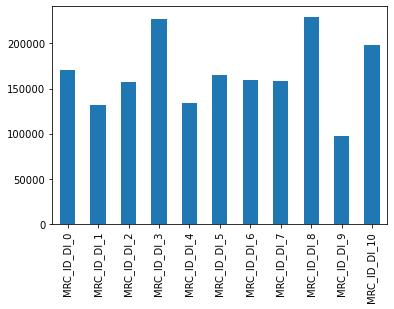

In [11]:
y_train.iloc[:,:].sum(axis=0).plot.bar()

In [6]:
raw_dataframe = pd.read_csv(val_y_name) #판다스이용 csv파일 로딩
raw_dataframe.info() # 데이터 정보 출력
del raw_dataframe['cst_id_di'] # 첫째열와 행 제거
y_valid = raw_dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28543 entries, 0 to 28542
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   cst_id_di     28543 non-null  int64
 1   MRC_ID_DI_0   28543 non-null  int64
 2   MRC_ID_DI_1   28543 non-null  int64
 3   MRC_ID_DI_2   28543 non-null  int64
 4   MRC_ID_DI_3   28543 non-null  int64
 5   MRC_ID_DI_4   28543 non-null  int64
 6   MRC_ID_DI_5   28543 non-null  int64
 7   MRC_ID_DI_6   28543 non-null  int64
 8   MRC_ID_DI_7   28543 non-null  int64
 9   MRC_ID_DI_8   28543 non-null  int64
 10  MRC_ID_DI_9   28543 non-null  int64
 11  MRC_ID_DI_10  28543 non-null  int64
dtypes: int64(12)
memory usage: 2.6 MB


In [10]:
y_valid.iloc[:,:].sum(axis=0)

MRC_ID_DI_0     19236
MRC_ID_DI_1       405
MRC_ID_DI_2        65
MRC_ID_DI_3       141
MRC_ID_DI_4        50
MRC_ID_DI_5       697
MRC_ID_DI_6      2695
MRC_ID_DI_7      3220
MRC_ID_DI_8      1630
MRC_ID_DI_9       288
MRC_ID_DI_10      135
dtype: int64

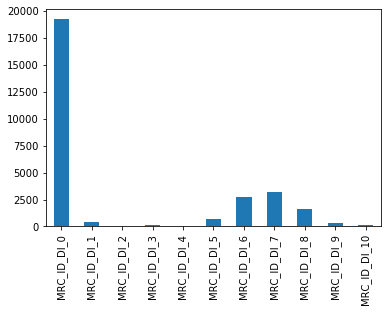

In [11]:
y_valid.iloc[:,:].sum(axis=0).plot.bar()

In [16]:
def get_tail_label(df: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = df.sum(axis=0)
    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & ((irlbl < irlbl.quantile(ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = irlbl.median()
    tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    tail_labels = get_tail_label(y, ql=ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_sample, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

In [17]:
y_train[y_train['MRC_ID_DI_0']==0].shape

(484180, 11)

In [18]:
x_train[y_train['MRC_ID_DI_0']==0].shape

(484180, 226)

In [19]:
for i in range(100):
    X_sub, y_sub = get_minority_samples(x_train[y_train['MRC_ID_DI_0']==0], y_train[y_train['MRC_ID_DI_0']==0])  # Getting minority samples of that datframe
    X_res, y_res = MLSMOTE(X_sub, y_sub, 2000, 5)  # Applying MLSMOTE to augment the dataframe
    x_train = pd.concat([x_train, X_res], axis=0)
    y_train = pd.concat([y_train, y_res], axis=0)
    print(i)

KeyboardInterrupt: 

In [20]:
y_train.iloc[:,:].sum(axis=0)

MRC_ID_DI_0     170768
MRC_ID_DI_1     141033
MRC_ID_DI_2     164704
MRC_ID_DI_3     237083
MRC_ID_DI_4     142790
MRC_ID_DI_5     173793
MRC_ID_DI_6     172130
MRC_ID_DI_7     163935
MRC_ID_DI_8     242784
MRC_ID_DI_9     103481
MRC_ID_DI_10    206999
dtype: int64

In [21]:
y_res.shape

NameError: name 'y_res' is not defined

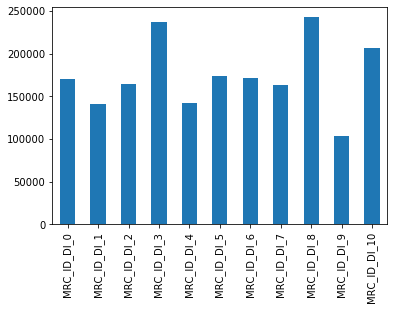

In [22]:
y_train.iloc[:,:].sum(axis=0).plot.bar()

In [7]:
from sklearn.preprocessing import RobustScaler
rs=RobustScaler()
x_train2 = rs.fit_transform(x_train)
x_valid2 = rs.fit_transform(x_valid)

In [7]:
input = keras.layers.Input(shape=(226,))
h1 = keras.layers.Dense(226, activation='sigmoid')(input)
h2 = keras.layers.Dense(226, activation='sigmoid')(h1)
h3 = keras.layers.Dense(226, activation='sigmoid')(h2)
h4 = keras.layers.Dense(113, activation='sigmoid')(h3)
h5 = keras.layers.Dense(113, activation='sigmoid')(h4)
added = keras.layers.Add()([h4, h5])
h6 = keras.layers.Dense(113, activation='sigmoid')(added)
added2 = keras.layers.Add()([h4, h6])
h7 = keras.layers.Dense(113, activation='sigmoid')(added2)
added3 = keras.layers.Add()([h4, h7])
h8 = keras.layers.Dense(113, activation='sigmoid')(added3)
h9 = keras.layers.Dense(113, activation='sigmoid')(h8)
out = keras.layers.Dense(11, activation='sigmoid')(h9)

model = keras.models.Model(inputs=[input], outputs=out)
    
    
model.compile(optimizer=keras.optimizers.Adam(lr=0.005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#skf=StratifiedKFold(n_splits=5, random_state=42, shuffle=True) # n_splits : 분할 횟수 , shuffle : 데이터 섞음(stratify효과)
x_train3=np.array(x_train)
y_train3=np.array(y_train)
x_valid3=np.array(x_valid)
y_valid3=np.array(y_valid)

#label_encoder = LabelEncoder()
#y_train3 = label_encoder.fit_transform(y_train3)
#y_valid3 = label_encoder.fit_transform(y_valid3)

print(x_train3)
print(y_train3)
print(x_valid3)
print(y_valid3)

deep_result=0
count = 1
'''
for i, (train_index, valid_index) in enumerate(skf.split(x_train3, y_train3.argmax(1))):
    print(valid_index)
    filename = 'best'+str(count)+'.h5'
    x_train4=x_train3[train_index]
    x_valid4=x_train3[valid_index]
    y_train4=y_train3[train_index]
    y_valid4=y_train3[valid_index]
    print(x_train4.shape)
    print(y_train4.shape)
    print(x_valid4.shape)
    print(y_valid4.shape)
    
    y = np.sum(y_valid4, axis=1)
    print(y)
    
    rl=ReduceLROnPlateau(patience = 5, verbose=1, factor=0.2)
    es=EarlyStopping(patience=10,verbose=1) # val_loss가 안좋아지면 멈춤, patience : val_loss값이 이전보다 감소하면 멈춤, 몇 번 감소하는지 설정
    mc=ModelCheckpoint(filename,save_best_only=True,verbose=1) # verbose : 분석 과정에 결과 띄움
    
    KERAS_PARAMS = dict(epochs=1000, validation_data=(x_valid4,y_valid4), callbacks=[es,mc,rl])
    
    clf = BinaryRelevance(classifier=Keras(model, True, KERAS_PARAMS), require_dense=[True,True])
    clf.fit(x_train4,y_train4)
    clf.load_weights(filename)
        
    #model.fit(x_train4,y_train4,epochs=1000,validation_data=(x_valid4,y_valid4),callbacks=[es,mc,rl]) 
    #model.load_weights(filename)
    
    #model.evaluate(x_valid4,  y_valid4, verbose=2)
    deep_result += clf.predict(x_valid3)/5

print(x_train3.shape)
print(y_train3.shape)
print(x_valid3.shape)
print(y_valid3.shape)
'''

filename = 'best.h5'
rl=ReduceLROnPlateau(patience = 5, verbose=1, factor=0.5)
es=EarlyStopping(patience=20,verbose=1) # val_loss가 안좋아지면 멈춤, patience : val_loss값이 이전보다 감소하면 멈춤, 몇 번 감소하는지 설정
mc=ModelCheckpoint(filename,save_best_only=True,verbose=1) # verbose : 분석 과정에 결과 띄움

#KERAS_PARAMS = dict(epochs=1000, validation_data=(x_valid3,y_valid3), callbacks=[es,mc,rl])
    
#clf = BinaryRelevance(classifier=Keras(model, True, KERAS_PARAMS), require_dense=[True,True])
#clf.fit(x_train3,y_train3)
#clf.load_weights(filename)


mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for train_index, test_index in mskf.split(x_train,y_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_valid = x_train3[train_index], x_train3[test_index]
    Y_train, Y_valid = y_train3[train_index], y_train3[test_index]
    
    model.fit(X_train,Y_train,epochs=10,validation_data=(x_valid3,y_valid3),callbacks=[es,mc,rl])

'''   
model.fit(x_train3,y_train3,epochs=30,validation_data=(x_valid3,y_valid3),callbacks=[es,mc,rl])
model.load_weights(filename)
deep_result = model.predict(x_valid3)
'''

# deep_ovr = roc_auc_score(y_valid3, model.predict(x_valid3),multi_class="ovr") # multi_class="ovr, ovo"
# print("ovr = ", deep_ovr)
print(deep_result)

[[-2.43800000e-02  5.57400000e-01  3.33000000e-02 ... -8.80000000e-04
  -2.79060000e-01  2.46570000e-01]
 [ 1.63500000e-02  9.84000000e-01  3.33430000e-01 ... -2.48430000e-01
  -3.91120000e-01  4.29280000e-01]
 [-2.63400000e-02  1.27900000e-01 -1.18870000e-01 ...  4.41200000e-02
  -1.67660000e-01  3.62130000e-01]
 ...
 [-8.42995110e-02  2.27848607e-01 -1.61062177e-01 ...  5.09767650e-02
   2.31016954e-01 -3.33610521e-01]
 [-7.42409340e-02  2.59634620e-02 -7.85356180e-02 ...  1.91327000e-02
   2.87933660e-02 -2.73591936e-01]
 [-6.51639050e-02  3.95852524e-01 -1.09394049e-01 ...  2.25141520e-02
   2.61644535e-01 -9.85264490e-02]]
[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 1]
 [0 1 0 ... 1 1 0]
 [0 0 1 ... 0 1 1]]
[[-0.03139  0.9779   0.30034 ... -0.10555 -0.35997  0.29996]
 [-0.03467  0.4181  -0.02969 ... -0.00282  0.14976 -0.15703]
 [-0.07021  0.1092  -0.19928 ...  0.02012  0.2871  -0.44233]
 ...
 [ 0.27469  0.9625   0.46168 ... -0.1347  -0.2424   0.34

C:\Users\hyowon\anaconda3\envs\SCDC\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


TRAIN: [     1      2      3 ... 654945 654946 654947] TEST: [     0     12     17 ... 654931 654932 654941]
Train on 524388 samples, validate on 28543 samples
Epoch 1/10
524388/524388 [==============================] - 45s 86us/step - loss: 0.5712 - accuracy: 0.7338 - val_loss: 0.3945 - val_accuracy: 0.9090

Epoch 00001: val_loss improved from inf to 0.39449, saving model to best.h5
Epoch 2/10
524388/524388 [==============================] - 56s 106us/step - loss: 0.5711 - accuracy: 0.7338 - val_loss: 0.4270 - val_accuracy: 0.9090

Epoch 00002: val_loss did not improve from 0.39449
Epoch 3/10
524388/524388 [==============================] - 55s 105us/step - loss: 0.5712 - accuracy: 0.7338 - val_loss: 0.4136 - val_accuracy: 0.9090

Epoch 00003: val_loss did not improve from 0.39449
Epoch 4/10
524388/524388 [==============================] - 53s 100us/step - loss: 0.5712 - accuracy: 0.7338 - val_loss: 0.4057 - val_accuracy: 0.9090

Epoch 00004: val_loss did not improve from 0.39449
Epoc

524023/524023 [==============================] - 56s 107us/step - loss: 0.5705 - accuracy: 0.7336 - val_loss: 0.4064 - val_accuracy: 0.9090

Epoch 00007: val_loss did not improve from 0.38713
Epoch 8/10
524023/524023 [==============================] - 57s 108us/step - loss: 0.5705 - accuracy: 0.7336 - val_loss: 0.4061 - val_accuracy: 0.9090

Epoch 00008: val_loss did not improve from 0.38713
Epoch 9/10
524023/524023 [==============================] - 55s 104us/step - loss: 0.5705 - accuracy: 0.7336 - val_loss: 0.4032 - val_accuracy: 0.9090

Epoch 00009: val_loss did not improve from 0.38713
Epoch 10/10
524023/524023 [==============================] - 57s 108us/step - loss: 0.5705 - accuracy: 0.7336 - val_loss: 0.4090 - val_accuracy: 0.9090

Epoch 00010: val_loss did not improve from 0.38713
TRAIN: [     0      1      2 ... 654945 654946 654947] TEST: [    13     21     34 ... 654938 654942 654944]
Train on 523866 samples, validate on 28543 samples
Epoch 1/10
523866/523866 [============

In [24]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train3,y_train3,epochs=5,validation_data=(x_valid3,y_valid3),callbacks=[es,mc,rl]) 
#model.load_weights(filename)
deep_result = model.predict(x_valid3)
print(deep_result)

Train on 654948 samples, validate on 28543 samples
Epoch 1/5
654948/654948 [==============================] - 66s 101us/step - loss: 0.4640 - accuracy: 0.7741 - val_loss: 0.4922 - val_accuracy: 0.7831

Epoch 00001: val_loss did not improve from 0.39101
Epoch 2/5
654948/654948 [==============================] - 60s 92us/step - loss: 0.4692 - accuracy: 0.7722 - val_loss: 0.4420 - val_accuracy: 0.8212

Epoch 00002: val_loss did not improve from 0.39101
Epoch 3/5
654948/654948 [==============================] - 61s 93us/step - loss: 0.4675 - accuracy: 0.7722 - val_loss: 0.5037 - val_accuracy: 0.7766

Epoch 00003: val_loss did not improve from 0.39101
Epoch 4/5
654948/654948 [==============================] - 61s 93us/step - loss: 0.4697 - accuracy: 0.7712 - val_loss: 0.4418 - val_accuracy: 0.8154

Epoch 00004: val_loss did not improve from 0.39101
Epoch 5/5
654948/654948 [==============================] - 61s 93us/step - loss: 0.4678 - accuracy: 0.7725 - val_loss: 0.4796 - val_accuracy: 0.

In [31]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for train_index, test_index in mskf.split(x_train3,y_train3):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_valid = x_train3[train_index], x_train3[test_index]
    Y_train, Y_valid = y_train3[train_index], y_train3[test_index]
    
    model.fit(X_train,Y_train,epochs=3,validation_data=(x_valid3,y_valid3),callbacks=[es,mc,rl])
    
#model.fit(x_train3,y_train3,epochs=1,validation_data=(x_valid3,y_valid3),callbacks=[es,mc,rl]) 
model.load_weights(filename)
deep_result = model.predict(x_valid3)

C:\Users\hyowon\anaconda3\envs\SCDC\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


KeyboardInterrupt: 

In [8]:
input = keras.layers.Input(shape=(226,))
h1 = keras.layers.Dense(226, activation='sigmoid')(input)
h2 = keras.layers.Dense(226, activation='sigmoid')(h1)
h3 = keras.layers.Dense(226, activation='sigmoid')(h2)
h4 = keras.layers.Dense(113, activation='sigmoid')(h3)
h5 = keras.layers.Dense(113, activation='sigmoid')(h4)
added = keras.layers.Add()([h4, h5])
h6 = keras.layers.Dense(113, activation='sigmoid')(added)
added2 = keras.layers.Add()([h4, h6])
h7 = keras.layers.Dense(113, activation='sigmoid')(added2)
added3 = keras.layers.Add()([h4, h7])
h8 = keras.layers.Dense(113, activation='sigmoid')(added3)
h9 = keras.layers.Dense(113, activation='sigmoid')(h8)
out = keras.layers.Dense(11, activation='sigmoid')(h9)

model = keras.models.Model(inputs=[input], outputs=out)

x_valid3 = np.array(x_valid)

model.load_weights("0.82_0(model1_no_robust).h5")
deep_result = model.predict(x_valid3)

In [9]:
input = keras.layers.Input(shape=(226,))
h1 = keras.layers.Dense(226, activation='sigmoid')(input)
h2 = keras.layers.Dense(226, activation='sigmoid')(h1)
h3 = keras.layers.Dense(226, activation='sigmoid')(h2)
#h4 = keras.layers.Dense(113, activation='sigmoid')(h3)
#h5 = keras.layers.Dense(113, activation='sigmoid')(h4)
#added = keras.layers.Add()([h4, h5])
#h6 = keras.layers.Dense(113, activation='sigmoid')(added)
#added2 = keras.layers.Add()([h4, h6])
#h7 = keras.layers.Dense(113, activation='sigmoid')(added2)
#added3 = keras.layers.Add()([h4, h7])
#h8 = keras.layers.Dense(113, activation='sigmoid')(added3)
#h9 = keras.layers.Dense(113, activation='sigmoid')(h8)
out = keras.layers.Dense(11, activation='sigmoid')(h3)

model2 = keras.models.Model(inputs=[input], outputs=out)

In [10]:
model2.load_weights("0.77_78.6(model2_robust).h5")
deep_result2 = model2.predict(x_valid2)

In [56]:
model2.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.fit(x_train3,y_train3,epochs=5,validation_data=(x_valid3,y_valid3),callbacks=[es,mc,rl])

Train on 654948 samples, validate on 28543 samples
Epoch 1/5
654948/654948 [==============================] - 43s 66us/step - loss: 0.3958 - accuracy: 0.8125 - val_loss: 0.6925 - val_accuracy: 0.8017

Epoch 00001: val_loss did not improve from 0.37189
Epoch 2/5
654948/654948 [==============================] - 43s 65us/step - loss: 0.3680 - accuracy: 0.8277 - val_loss: 0.8699 - val_accuracy: 0.7958

Epoch 00002: val_loss did not improve from 0.37189
Epoch 3/5
654948/654948 [==============================] - 43s 65us/step - loss: 0.3500 - accuracy: 0.8369 - val_loss: 0.9286 - val_accuracy: 0.7847

Epoch 00003: val_loss did not improve from 0.37189
Epoch 4/5
654948/654948 [==============================] - 44s 68us/step - loss: 0.3371 - accuracy: 0.8432 - val_loss: 0.9551 - val_accuracy: 0.7938

Epoch 00004: val_loss did not improve from 0.37189
Epoch 5/5
654948/654948 [==============================] - 42s 64us/step - loss: 0.3275 - accuracy: 0.8477 - val_loss: 1.0170 - val_accuracy: 0.7

In [8]:
deep_result = model.predict(x_valid3)
deep_ovr = roc_auc_score(y_valid3,deep_result,multi_class="ovr") # multi_class="deep_over, ovo"
print("deep_ovr = ", deep_ovr)

deep_ovr =  0.500725909372428


In [10]:
p = model.predict(np.array([x_train3[90]]))
print(p)

[[0.05822675 0.34009624 0.04850496 0.12315792 0.02290238 0.47186127
  0.5508556  0.27122962 0.5981812  0.09425732 0.09624963]]


In [19]:
x_train3[90].shape

(226,)

In [20]:
y_train3[90]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=int64)

In [10]:
def refineData(predict):
    container = np.zeros((len(predict), 2), dtype=float)
    
    num = 0
    
    for i in predict:      
        maxValue = 0
        count = 0
        
        
        for j in range(11):
            if maxValue < i[j]:
                maxValue = i[j]
                count = j
        
        container[num][0] = maxValue
        container[num][1] = count
             
        num += 1

        
    return container

In [11]:
def sortConfidence(data):
    for i in range(len(data)-1):
        
        for j in range(len(data)-i):
            if data[i][0] < data[i+j][0]:
                #print(i, j, data[i], data[i+j])
                data[i][0],data[i+j][0] = data[i+j][0],data[i][0]
                data[i][1],data[i+j][1] = data[i+j][1],data[i][1]
                #print(i, j, data[i], data[i+j])
    
    return data

In [12]:
predict_result = model.predict(x_valid)
container = refineData(predict_result)
print(container)

sortedData = sortConfidence(container)
print(sortedData)

[[ 0.94034171  0.        ]
 [ 0.6014663  10.        ]
 [ 0.84565324 10.        ]
 ...
 [ 0.71933079  0.        ]
 [ 0.607669    0.        ]
 [ 0.83592594  8.        ]]


KeyboardInterrupt: 

In [19]:
pd.DataFrame(predict_result).to_csv('predict.csv')

In [13]:
def arrayCount(top_20):
    p_rate = np.zeros(11, dtype=float)
    
    for i in range(11):
        count = 0
        for j in top_20:
            if j[1] == i:
                count += 1
                
        p_rate[i] = count/len(top_20)
        
    return p_rate

In [14]:
def arrayCount2(y):
    real_rate = np.zeros(11, dtype=float)
    
    for i in range(11):
        count = 0
        for j in y:
            if j[i] == 1:
                count += 1
                
        real_rate[i] = count/len(y)
        
    return real_rate

In [15]:
top_20_num = int(len(sortedData)*0.2)
top_20_Data = sortedData[:top_20_num]
p_rate = arrayCount(top_20_Data)

real_rate = arrayCount2(y_valid3)
real_rate2 = arrayCount(sortedData)
real_rate3 = arrayCount2(y_train3)
print(y_valid.shape)
print(real_rate)
print(real_rate2)
print(real_rate3)
score_array = p_rate / real_rate
print(score_array)
lift_score = np.sum(score_array)/11
print("LIFT_score = ", lift_score)

(28543, 11)
[0.67393056 0.01418912 0.00227727 0.00493992 0.00175174 0.0244193
 0.09441895 0.11281225 0.05710682 0.01009004 0.00472971]
[0.36607925 0.         0.         0.25169043 0.         0.
 0.         0.         0.20579477 0.         0.17643555]
[0.2607352  0.21533465 0.25147645 0.36198752 0.21801731 0.26535389
 0.26281476 0.25030231 0.37069202 0.1579988  0.3160541 ]
[1.44301921 0.         0.         0.         0.         0.
 0.         0.         0.48164572 0.         0.        ]
LIFT_score =  0.17496953846820215


In [10]:
def target_score(model_predict, y_valid, test_y, target_class):
    y_test=y_valid
    y_score=model_predict
    len_top20=np.int(np.round(len(model_predict)*0.2))

    lw = 2
    n_classes = len(target_class)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in [3,4,7]:
        fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(np.array(y_test).ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in [3,4,7]]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in [3,4,7]:
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # lift score
    top20=pd.DataFrame(model_predict).apply(lambda x: max(x), axis=1).sort_values(ascending=False)[:len_top20]
    pred20=np.array(pd.DataFrame(model_predict).iloc[top20.index]).argmax(axis=1)
    
    target_lift=0
    target_lift+=(len(pred20[pred20==3])/len(pred20))/(len(test_y[test_y.iloc[:,3]==1])/len(test_y))
    target_lift+=(len(pred20[pred20==4])/len(pred20))/(len(test_y[test_y.iloc[:,4]==1])/len(test_y))
    target_lift+=(len(pred20[pred20==7])/len(pred20))/(len(test_y[test_y.iloc[:,7]==1])/len(test_y))
    target_lift=target_lift/3
    
    target_final = (0.7*(target_lift/5)) + (0.3*(roc_auc['micro'] + roc_auc['macro'])/2)
    
    print(roc_auc)
    print('mean(micro, macro)', (roc_auc['micro'] + roc_auc['macro'])/2)
    print('target_lift :', target_lift)
    print('target_final :', target_final)

In [14]:
def target_score(model_predict, y_valid, test_y, target_class):
    y_test=y_valid
    y_score=model_predict
    

    lw = 2
    n_classes = len(target_class)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in target_class:
        fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(np.array(y_test).ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in [3,4,7]]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in target_class:
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # lift score
    len_top20=np.int(np.round(len(model_predict)*0.2))
    top20=pd.DataFrame(model_predict).apply(lambda x: max(x), axis=1).sort_values(ascending=False)[:len_top20]
    pred20=np.array(pd.DataFrame(model_predict).iloc[top20.index]).argmax(axis=1)

    target_lift=0
    for i in target_class:
        target_lift+=(len(pred20[pred20==i])/len(pred20))/(len(test_y[test_y.iloc[:,i]==1])/len(test_y))

    target_lift=target_lift/len(target_class)

    target_final = (0.7*(target_lift/5)) + (0.3*(roc_auc['micro'] + roc_auc['macro'])/2)

    print(roc_auc)
    print('mean(micro, macro)', (roc_auc['micro'] + roc_auc['macro'])/2)
    print('target_lift :', target_lift)
    print('target_final :', target_final)

In [15]:
def totality_score(model_predict, y_valid, test_y):
    auroc_macro=roc_auc_score(np.array(y_valid), model_predict,multi_class="ovr", average= 'macro')
    auroc_micro=roc_auc_score(np.array(y_valid), model_predict,multi_class="ovr", average= 'micro')

    len_top20=np.int(np.round(len(model_predict)*0.2))

    top20=pd.DataFrame(model_predict).apply(lambda x: max(x), axis=1).sort_values(ascending=False)[:len_top20]
    pred20=np.array(pd.DataFrame(model_predict).iloc[top20.index]).argmax(axis=1)

    lift_score=0
    for i in range(11):
        lift_score+=(len(pred20[pred20==i])/len(pred20))/(len(test_y[test_y.iloc[:,i]==1])/len(test_y))
    lift_score=lift_score/(len(test_y.columns)-1)

    final_score_macro = (0.7*(lift_score/5)) + (0.3*auroc_macro)
    final_score_micro = (0.7*(lift_score/5)) + (0.3*auroc_micro)

    print('auroc_macro :', auroc_macro)
    print('auroc_micro :', auroc_micro)
    print('lift_score :', lift_score)
    print('final_score_micro :', final_score_micro)
    print('final_score_macro :', final_score_macro)

In [16]:
predict_result = model.predict(x_valid)
predict_result2 = model2.predict(np.array(x_valid2))
predict_result = predict_result*0.35 + predict_result2*0.65
target_score(predict_result, y_valid, y_valid, [3,4,7])
totality_score(predict_result, y_valid, y_valid)

C:\Users\hyowon\anaconda3\envs\SCDC\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


{3: 0.8015098327407769, 4: 0.8595247955638227, 7: 0.7680277031927619, 'micro': 0.7730448514470423, 'macro': 0.809815599470952}
mean(micro, macro) 0.7914302254589971
target_lift : 3.073070722806303
target_final : 0.6676589688305814
auroc_macro : 0.8077137524919302
auroc_micro : 0.7730448514470423
lift_score : 1.6458207156883433
final_score_micro : 0.46232835563048075
final_score_macro : 0.4727290259439471


In [12]:
predict_result = model.predict(x_valid)
predict_result2 = model2.predict(np.array(x_valid2))

predict_result = pd.DataFrame(predict_result)
predict_result2 = pd.DataFrame(predict_result2)

predict_result.to_csv('predict.csv')
predict_result2.to_csv('predict2.csv')

In [25]:
len_top20=np.int(np.round(len(predict_result)*0.2))

ensemble_top20=pd.DataFrame(predict_result).apply(lambda x: max(x), axis=1).sort_values(ascending=False)[:len_top20]
ensemble_pred20=np.array(pd.DataFrame(predict_result).iloc[ensemble_top20.index]).argmax(axis=1)

lift_score=0
for i in range(11):
    lift_score+=(len(ensemble_pred20[ensemble_pred20==i])/len(ensemble_pred20))/(len(y_valid[y_valid.iloc[:,i+1]==1])/len(y_valid))
lift_score=lift_score/(len(y_valid3.columns)-1)
lift_score

IndexError: single positional indexer is out-of-bounds